---
title: "Looking into YouTube Free Movies"
subtitle: "You get what you (don't) pay for"
date: 2020-06-01
categories: 
  - Python
tags: 
  - munging
  - cleaning
  - movies
slug: "youtube-movies"
links:
- icon: external-link-alt
  icon_pack: fas
  name: Jupyter Notebook
  url: https://github.com/zachbogart/my_website/blob/master/content/post/2020-05-25-youtube-movies/2020-05-25-youtube-movies.ipynb
- icon: mug-hot
  icon_pack: fas
  name: Give a Coffee
  url: https://ko-fi.com/zachbogart
  
---

I saw that YouTube had [a wide selection of movies](https://www.youtube.com/movies), but the free movies didn't seem very good. Was interested in seeing what kind of ratings the free movies on YouTube receive. Let's figure it out!

## Go to the Movies

To start, let's import some things.

In [82]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

We can use `requests` to grab the html.

In [11]:
url = 'https://www.youtube.com/feed/storefront?bp=kgEmCGQSIlBMSFBUeFR4dEMwaWJWWnJUMl9XS1dVbDJTQXhzS3VLd3iiBQIoAg%3D%3D'
page = requests.get(url)


In [12]:
soup = BeautifulSoup(page.text, 'html.parser')

In [13]:
print(soup.prettify()[:200])


<!DOCTYPE html>
<html data-cast-api-enabled="true" lang="en">
 <head>
  <style name="www-roboto">
   @font-face{font-family:'Roboto';font-style:normal;font-weight:500;src:local('Roboto Medium'),local(


At this point, we can do some inspecting to find that each film has a `yt-lockup-title` class that we can access. With a little bit of fiddling, we can get a dataframe of the movie names. There is also a common format which we can use to split the strings into separate columns.

In [14]:
html_films = soup.find_all(class_="yt-lockup-title")

for film in html_films[:5]:
    print(film.get_text())

Dino King - Duration: 1:28:47.
Snow Queen - Duration: 1:16:07.
Beyond Beyond - Duration: 1:19:24.
Igor (U.S) - Duration: 1:26:31.
Sleepover - Duration: 1:29:29.


In [15]:
movies = [film.get_text() for film in html_films]

In [16]:
movies[:6]

['Dino King - Duration: 1:28:47.',
 'Snow Queen - Duration: 1:16:07.',
 'Beyond Beyond - Duration: 1:19:24.',
 'Igor (U.S) - Duration: 1:26:31.',
 'Sleepover - Duration: 1:29:29.',
 'The Secret of Nimh - Duration: 1:22:46.']

In [17]:
df = pd.DataFrame(movies)
df.rename(columns={0: 'movie'}, inplace=True)

In [18]:
df[df.movie.str.contains(' - Duration: ')].head()

,movie
0,Dino King - Duration: 1:28:47.
1,Snow Queen - Duration: 1:16:07.
2,Beyond Beyond - Duration: 1:19:24.
3,Igor (U.S) - Duration: 1:26:31.
4,Sleepover - Duration: 1:29:29.


In [19]:
df = df.movie.str.split(' - Duration: ', expand=True)

In [20]:
df[1] = df[1].str.rstrip('.')

In [21]:
df = df.reset_index()

In [22]:
df.rename(columns={0: 'yt_title', 1: 'yt_duration', 'index': 'yt_id'}, inplace=True)

In [23]:
df.head()

,yt_id,yt_title,yt_duration
0,0,Dino King,1:28:47
1,1,Snow Queen,1:16:07
2,2,Beyond Beyond,1:19:24
3,3,Igor (U.S),1:26:31
4,4,Sleepover,1:29:29


### Convert Duration to minutes
The string movie time doesn't mean much to us. Let's turn it into minutes.

In [24]:
def split_time(x):
    numbers = x.split(':')
    time = int(numbers[0]) * 60 + int(numbers[1])
    return time

In [25]:
df['yt_minutes'] = df['yt_duration'].apply(split_time)

## IMDb Data
- We will use data from the IMDb datasets to get info on the movie ratings.

In [27]:
imdb_ratings = pd.read_csv('/Users/zachbogart/Downloads/title.ratings.tsv', sep='\t')
imdb_basics = pd.read_csv('/Users/zachbogart/Downloads/title.basics.tsv', sep='\t')

/Users/zachbogart/Documents/venv-breadbasket/sourdough_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
imdb = imdb_basics.merge(imdb_ratings, how='left', on='tconst')

In [29]:
imdb.shape

(6831547, 11)

Let's look just at items that are `movie`s

In [30]:
imdb.titleType.value_counts()

tvEpisode       4869408
short            741081
movie            551301
video            265727
tvSeries         184466
tvMovie          121175
tvMiniSeries      31078
tvSpecial         29209
videoGame         25548
tvShort           12554
Name: titleType, dtype: int64

In [31]:
imdb = imdb.loc[imdb.titleType == 'movie']

In [32]:
imdb.shape

(551301, 11)

In [33]:
imdb.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.9,153.0
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport",5.2,346.0
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",6.1,40.0
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,3.8,6.0
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",6.1,574.0


## Try Joining

We are playing this pretty fast and loose, but we can get a rough sense of the movie ratings using a simple join and dropping any corner cases.

In [34]:
joined = df.merge(imdb, how='left', left_on='yt_title', right_on='primaryTitle')

In [35]:
# remove any values with null
joined = joined.dropna().sort_values('primaryTitle')

Let's not deal with any overlap. Just the movies that have one match (Could also try to match durations to get more movies, but let's ignore that right now).
- there are a bunch of items with multiple results
- Let's see what we have without trying to dig out overlapping movies

In [36]:
joined.yt_title.value_counts()

Romeo and Juliet      10
Happily Ever After    10
Zoo                   10
The Suspect            8
Gone                   8
                      ..
A Cowgirl's Story      1
Mad Money              1
Bakery in Brooklyn     1
Snow Queen             1
17 Miracles            1
Name: yt_title, Length: 262, dtype: int64

In [42]:
singles = joined.groupby('yt_title')['yt_title'].filter(lambda x: len(x) == 1)

In [94]:
easy = joined[joined.yt_title.isin(singles)]

# What Do We Find?

## The Highest (and Lowest) Rated
- What are the top-rated movies available? Worst Rated?

In [95]:
cols = ['yt_title', 'averageRating', 'numVotes']

In [96]:
easy[cols].sort_values('averageRating', ascending=False).head(10)

,yt_title,averageRating,numVotes
478,The Usual Suspects,8.5,956313.0
429,Zeitgeist: Moving Forward,8.2,17246.0
440,Bones Brigade: An Autobiography,8.1,2306.0
433,Requiem for the American Dream,8.1,8297.0
712,Citizenfour,8.0,50670.0
413,Sound City,7.8,11887.0
308,Muscle Shoals,7.7,3400.0
303,"Fat, Sick & Nearly Dead",7.5,8338.0
272,The Secret of Roan Inish,7.5,6792.0
319,Unbranded,7.4,1326.0


In [97]:
easy[cols].sort_values('averageRating').head(10)

,yt_title,averageRating,numVotes
10,Disaster Movie,1.9,85558.0
636,Alcatraz,3.3,359.0
169,Spiders 3D,3.3,3960.0
707,The Remains,3.7,2870.0
513,Fist of the Warrior,3.8,369.0
740,Fishing Naked,4.0,782.0
160,Ribbit,4.0,611.0
74,Hollow Creek,4.2,592.0
327,Arthur & Merlin,4.3,1226.0
611,Out of Liberty,4.4,262.0


## How Old Are These Movies?
- Most are a few years old. Some are decades old.

In [104]:
easy['startYear'] = pd.to_numeric(easy.startYear)

/Users/zachbogart/Documents/venv-breadbasket/sourdough_venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


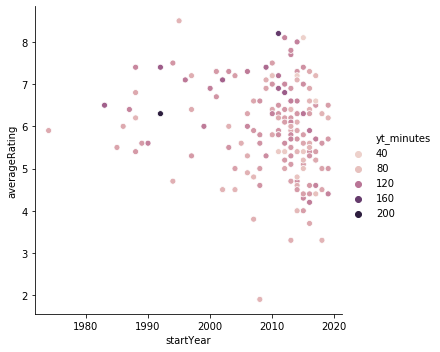

In [106]:
ax = sns.relplot(data=easy,
                x='startYear',
                y='averageRating',
                kind='scatter',
                hue='yt_minutes')
plt.show()

## Scraping the Bottom of the Barrel
- Looks like the movies are pretty poorly rated, averaging around 6 out of 10

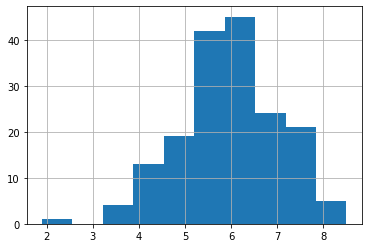

In [89]:
ax = easy.averageRating.hist()
plt.show()

In [69]:
print(f"{easy.averageRating.mean():.2f}")

5.95


## Overall
You get what you (don't) pay for.

#### Resources
- https://docs.python-guide.org/scenarios/scrape/
- https://www.digitalocean.com/community/tutorials/how-to-work-with-web-data-using-requests-and-beautiful-soup-with-python-3
- https://www.geeksforgeeks.org/split-a-text-column-into-two-columns-in-pandas-dataframe/


#### Image Credit
[integrated system](https://thenounproject.com/search/?q=integrated%20system&creator=4129988&i=3169228) by Zach Bogart from [the Noun Project](https://thenounproject.com/) 